# Data Exploration (Part V - Exploration & Analysis)
## Intro
At this point, we've gotten a feel for the data, but we really still don't know what's in it. After 9 posts, we're finally ready to actually explore haha... Oh, the miraculous world of data science...

Similar to the [All-NBA prediction](https://strikingmoose.com/category/1-all-nba-predict/) project I was doing, I really have no objective here. I came in just looking to use Spark and explore a hefty amount of Police calls, so let's just start with whatever is interesting to us.

## Incident Timestamps
I've been wondering about the time-based trends of the complaints since I was cleaning up the data... What's the trend year over year? What's months are most active with complaints? Day of the week? Hour of the day? Let's explore all of these.

In [1]:
import os
os.system("sudo pip install findspark sql_magic pyspark_dist_explore")

0

In [2]:
# Use findspark package to connect Jupyter to Spark shell
import findspark
findspark.init('/usr/lib/spark')

# Load SparkSession object
import pyspark
from pyspark.sql import SparkSession

# Load other libraries
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from functools import reduce
import pandas as pd
import numpy as np

# Graphing with matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Initiate SparkSession as "spark"
spark = SparkSession\
    .builder\
    .getOrCreate()

# Load sql_magic and connect to Spark
%load_ext sql_magic
%config SQL.conn_name = 'spark'

A few notes above:
1. I should be doing a lot more graphing from now on, so I'm going to try out the ggplot style of matplotlib, this is supposed to mimic R graph styles and color schemes. I've always liked [ggplot's color schemes](https://strikingmoose.com/2017/07/27/exploration-of-historical-nba-team-efficiency-part-ii/), so let's try it out.
2. When importing functions from the pyspark.sql package, I've been importing every single function separately... that's like importing every Pandas dataframe command individually when you need them... I've seen multiple folks import the entire pyspark.sq.functions package as the literal 'F' for some reason... I'll try this.

In [3]:
%%time
# Read NYPD Complaint Data
df = spark.read.parquet("s3n://2017edmfasatb/nypd_complaints/data/df_clean.parquet")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 17.5 s


The CSV, for reference, took ~50 seconds to load. The parquet load only took 15s, which I assume can be attributed to the fact that we don't have to infer any type of schema because the schema is built into the parquet itself and all Spark has to do is read the metadata. Good stuff!

In [4]:
df.printSchema()

root
 |-- COMPLAINT_NUMBER: integer (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP: timestamp (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_YEAR: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_MONTH: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_DAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_WEEKDAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_HOUR: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_YEAR: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_MONTH: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_DAY: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_WEEKDAY: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_HOUR: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_YEAR: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_MONTH: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_DAY:

In [5]:
# Add table to SQL Context
df.createOrReplaceTempView("df")

## Time-Based Analysis
### Annual Trend
Let's start with a simple annual trend.

In [6]:
complaint_start_result = %read_sql \
SELECT \
    COMPLAINT_START_TIMESTAMP_YEAR as COMPLAINT_YEAR, \
    COUNT(*) as NUM_COMPLAINTS \
FROM df \
GROUP BY COMPLAINT_START_TIMESTAMP_YEAR

Query started at 05:03:59 AM UTC; Query executed in 0.31 m

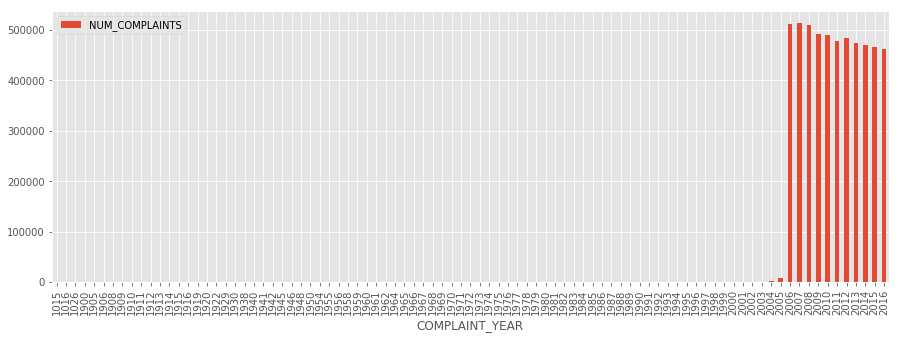

In [7]:
# Plot number of complaints per year
complaint_start_result.sort_values('COMPLAINT_YEAR').plot(kind = 'bar', x = 'COMPLAINT_YEAR', y = 'NUM_COMPLAINTS', figsize = (15, 5))

So the documentation for the data set says that it's got data from 2006 to the end of 2016, about 10 years worth. This is absolutely _**NOT**_ what I'm seeing in the data itself...

In [8]:
complaint_start_result.sort_values('COMPLAINT_YEAR').tail(20)

,COMPLAINT_YEAR,NUM_COMPLAINTS
59,1997,80
75,1998,143
56,1999,218
20,2000,720
78,2001,805
32,2002,782
83,2003,1189
47,2004,1685
18,2005,9489
39,2006,511118


For some reason, there are complaints pre-2006... how many records?

In [9]:
# Create a boolean flag for those records greater than or equal to the year 2006
complaint_start_result['2006_or_later'] = np.where(
    complaint_start_result['COMPLAINT_YEAR'].astype('int') >= 2006,
    '2006 Or Later',
    'Before 2006'
)

# Sum up number of complaints per category
complaint_start_result_grouped = complaint_start_result.groupby('2006_or_later').agg({'NUM_COMPLAINTS': [np.sum]}).reset_index()

In [10]:
# Calculate percentage of total
complaint_start_result_grouped['NUM_COMPLAINTS_PERCENT'] = (complaint_start_result_grouped['NUM_COMPLAINTS']['sum'] / complaint_start_result_grouped['NUM_COMPLAINTS']['sum'].sum())*100
complaint_start_result_grouped

,2006_or_later,NUM_COMPLAINTS,NUM_COMPLAINTS_PERCENT
,,sum,
0,2006 Or Later,5349485,99.706035
1,Before 2006,15772,0.293965


Okay, there are a negligible amount of rows where the incident started before 2006. Maybe the data set meant complaints that were _**reported**_ 2006 or after?

In [11]:
report_result = %read_sql \
SELECT \
    REPORTED_DATE_TIMESTAMP_YEAR as REPORTED_YEAR, \
    COUNT(*) as NUM_COMPLAINTS \
FROM df \
GROUP BY REPORTED_DATE_TIMESTAMP_YEAR

Query started at 05:04:28 AM UTC; Query executed in 0.07 m

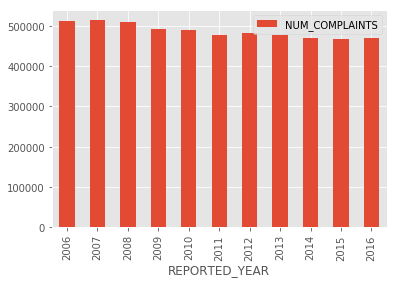

In [12]:
# Plot number of complaints per year
report_result.sort_values('REPORTED_YEAR').plot(kind = 'bar', x = 'REPORTED_YEAR', y = 'NUM_COMPLAINTS')

Okay, I guess that is what the dataset description meant. Anything that is was _**REPORTED**_ 2006 or later. This is fine, as it implies that there were incidents that were reported, in some cases, DECADES after they actually happened. There was even one in... 1015? I mean... the declaration of independence was on July 4th, 1776. Plus someone who was eben live in 1015 is now 1002 years old...

Let's see what the 1015 one is...

In [13]:
# Look at those rows which the incident started on the year 1015
df[df['COMPLAINT_START_TIMESTAMP_YEAR'] == 1015].toPandas()

,COMPLAINT_NUMBER,COMPLAINT_START_TIMESTAMP,COMPLAINT_END_TIMESTAMP,REPORTED_DATE_TIMESTAMP,COMPLAINT_START_TIMESTAMP_YEAR,COMPLAINT_START_TIMESTAMP_MONTH,COMPLAINT_START_TIMESTAMP_DAY,COMPLAINT_START_TIMESTAMP_WEEKDAY,COMPLAINT_START_TIMESTAMP_HOUR,COMPLAINT_END_TIMESTAMP_YEAR,...,OFFENSE_DESCRIPTION,OFFENSE_RESULT,OFFENSE_LEVEL,JURISDICTION,BOROUGH,PRECINCT,SPECIFIC_LOCATION,PREMISE_DESCRIPTION,LAT,LON
0,211843983,1015-12-10 16:45:00,1015-12-10 16:45:00,2015-12-10,1015,12,10,Sun,16,1015,...,FELONY ASSAULT,COMPLETED,FELONY,N.Y. POLICE DEPT,MANHATTAN,18,INSIDE,STREET,40.761311,-73.973083
1,131106711,1015-12-10 12:30:00,2015-12-10 12:40:00,2015-12-10,1015,12,10,Sun,12,2015,...,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,QUEENS,108,None,STREET,40.748137,-73.906245
2,821425869,1015-12-01 14:30:00,2015-12-01 14:40:00,2015-12-01,1015,12,1,Fri,14,2015,...,GRAND LARCENY,COMPLETED,FELONY,N.Y. POLICE DEPT,BROOKLYN,94,INSIDE,OTHER,40.717573,-73.962535
3,161924074,1015-10-02 12:11:00,2015-11-23 13:00:00,2015-11-23,1015,10,2,Mon,12,2015,...,GRAND LARCENY,COMPLETED,FELONY,N.Y. POLICE DEPT,MANHATTAN,25,None,STREET,40.804384,-73.937422
4,414788103,1015-11-02 19:30:00,1015-11-02 19:30:00,2015-11-05,1015,11,2,Thu,19,1015,...,PETIT LARCENY,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,BROOKLYN,75,INSIDE,RESIDENCE - APT. HOUSE,40.674073,-73.894438
5,148685327,1015-10-23 16:00:00,2015-10-23 16:05:00,2015-10-23,1015,10,23,Mon,16,2015,...,OTHER,COMPLETED,FELONY,N.Y. POLICE DEPT,BRONX,41,INSIDE,RESIDENCE - APT. HOUSE,40.819435,-73.894927
6,685788623,1015-02-14 16:13:00,2016-02-20 16:15:00,2016-04-04,1015,2,14,Tue,16,2016,...,PETIT LARCENY,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,BROOKLYN,90,INSIDE,OTHER,40.699359,-73.953832
7,388647572,1015-11-26 13:30:00,2015-12-03 14:00:00,2016-01-02,1015,11,26,Sun,13,2015,...,PETIT LARCENY,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,QUEENS,106,FRONT OF,RESIDENCE-HOUSE,40.651283,-73.841805


Welp, it looks like these were definitely typos. They should all be in the 2015 - 2016 range. It seems here that some 1015s should be 2015, and some should be 2016. For example, in row id \#6, you'd imagine that a small misdemeanor of Petit Larceny in Brooklyn lasted from 2016 to 2016... even then, though, it indicates that the incident lasted from February 14th to 20th, which I honestly can't be too sure of here. In any event, I guess my point is that I don't want to make assumptions about any of these dates or typos because I simply don't know much about the criminal system, and crimes in general. I think I'm going to take out all of these years that are in the 1000s millenium - they are typos and may mess with my analysis when I look at the time it took to report or the time it took for the incident to finish.

Let's take a look at the 1900 one:

In [14]:
# Look at those rows which the incident started on the year 1900
df[df['COMPLAINT_START_TIMESTAMP_YEAR'] == 1900].toPandas()

,COMPLAINT_NUMBER,COMPLAINT_START_TIMESTAMP,COMPLAINT_END_TIMESTAMP,REPORTED_DATE_TIMESTAMP,COMPLAINT_START_TIMESTAMP_YEAR,COMPLAINT_START_TIMESTAMP_MONTH,COMPLAINT_START_TIMESTAMP_DAY,COMPLAINT_START_TIMESTAMP_WEEKDAY,COMPLAINT_START_TIMESTAMP_HOUR,COMPLAINT_END_TIMESTAMP_YEAR,...,OFFENSE_DESCRIPTION,OFFENSE_RESULT,OFFENSE_LEVEL,JURISDICTION,BOROUGH,PRECINCT,SPECIFIC_LOCATION,PREMISE_DESCRIPTION,LAT,LON
0,857331711,1900-05-08 21:00:00,1900-05-08 21:00:00,2009-05-08,1900,5,8,Tue,21,1900,...,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,N.Y. HOUSING POLICE,MANHATTAN,23,FRONT OF,RESIDENCE - PUBLIC HOUSING,40.788861,-73.952004
1,346351111,1900-08-06 09:00:00,2010-01-01 19:00:00,2010-09-07,1900,8,6,Mon,9,2010,...,OTHER,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,19,INSIDE,RESIDENCE - APT. HOUSE,40.774602,-73.945017
2,130320181,1900-08-07 08:30:00,2006-08-07 19:00:00,2006-08-07,1900,8,7,Tue,8,2006,...,OTHER,COMPLETED,FELONY,N.Y. POLICE DEPT,BROOKLYN,61,INSIDE,RESIDENCE - APT. HOUSE,40.603887,-73.942543
3,944477711,1900-03-10 19:00:00,2006-03-19 19:00:00,2006-03-20,1900,3,10,Sat,19,2006,...,OTHER,COMPLETED,FELONY,N.Y. POLICE DEPT,BROOKLYN,66,INSIDE,RESIDENCE - APT. HOUSE,40.646130,-73.973227
4,667928187,1900-11-26 19:00:00,1900-11-26 19:00:00,2006-02-26,1900,11,26,Mon,19,1900,...,HARRASSMENT 2,COMPLETED,VIOLATION,N.Y. POLICE DEPT,MANHATTAN,13,INSIDE,RESIDENCE-HOUSE,40.735323,-73.984240


Hmm... many of these look like typos too. Row index \#1 has one going from 1900 to 2010, which is clearly a typo. I'm not sure exactly what the typo should be though... 1900 to 2010 is not even close. The ones from 1900 to 1900 are also kinda weird... why would someone in 2006 report a crime that happened in the 1900s? Maybe there is something I'm missing here, but it just doesn't make sense to me. Nowhere in the NYC [statute of limitations](https://www.nycourts.gov/courthelp/GoingToCourt/SOLchart.shtml) does any crime let you report _**100 years later**_, let alone if that person who any parties involved would still be alive then...

I'm not convinced of these 1900 ones so far... let's try one in 1980 to see an example of a crime where it's plausible that the reportee could even be alive.

In [15]:
# Look at those rows which the incident started on the year 1980
df[df['COMPLAINT_START_TIMESTAMP_YEAR'] == 1980].toPandas()

,COMPLAINT_NUMBER,COMPLAINT_START_TIMESTAMP,COMPLAINT_END_TIMESTAMP,REPORTED_DATE_TIMESTAMP,COMPLAINT_START_TIMESTAMP_YEAR,COMPLAINT_START_TIMESTAMP_MONTH,COMPLAINT_START_TIMESTAMP_DAY,COMPLAINT_START_TIMESTAMP_WEEKDAY,COMPLAINT_START_TIMESTAMP_HOUR,COMPLAINT_END_TIMESTAMP_YEAR,...,OFFENSE_DESCRIPTION,OFFENSE_RESULT,OFFENSE_LEVEL,JURISDICTION,BOROUGH,PRECINCT,SPECIFIC_LOCATION,PREMISE_DESCRIPTION,LAT,LON
0,344579314,1980-04-30 17:15:00,1980-04-30 17:15:00,2009-08-05,1980,4,30,Wed,17,1980,...,OTHER,COMPLETED,FELONY,N.Y. POLICE DEPT,BROOKLYN,79,INSIDE,OTHER,40.690629,-73.957927
1,141684222,1980-12-30 09:00:00,2013-07-01 09:00:00,2013-09-26,1980,12,30,Tue,9,2013,...,GRAND LARCENY,COMPLETED,FELONY,N.Y. POLICE DEPT,MANHATTAN,18,INSIDE,RESIDENCE - APT. HOUSE,40.759711,-73.993562
2,948543549,1980-01-30 12:00:00,2010-11-11 07:55:00,2010-11-18,1980,1,30,Wed,12,2010,...,OFF. AGNST PUB ORD SENSBLTY &,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,18,INSIDE,RESIDENCE - APT. HOUSE,40.763866,-73.984963
3,971565071,1980-03-22 07:15:00,1980-03-22 07:15:00,2014-06-24,1980,3,22,Sat,7,1980,...,OTHER,COMPLETED,FELONY,N.Y. POLICE DEPT,BRONX,43,INSIDE,OTHER,40.829629,-73.868243
4,856926861,1980-06-12 15:00:00,2008-06-16 08:00:00,2008-06-18,1980,6,12,Thu,15,2008,...,PETIT LARCENY,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,BRONX,48,INSIDE,PUBLIC SCHOOL,40.855017,-73.883075
5,812169194,1980-03-26 08:10:00,2008-03-26 15:13:00,2008-03-26,1980,3,26,Wed,8,2008,...,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,BROOKLYN,84,INSIDE,OTHER,40.703604,-73.981864
6,175109920,1980-02-01 08:00:00,1980-02-01 08:45:00,2008-02-01,1980,2,1,Fri,8,1980,...,DANGEROUS DRUGS,COMPLETED,FELONY,N.Y. POLICE DEPT,BRONX,45,INSIDE,RESIDENCE - APT. HOUSE,40.878649,-73.824083
7,203235148,1980-08-18 11:30:00,1980-08-18 11:30:00,2010-08-18,1980,8,18,Mon,11,1980,...,OTHER,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,BRONX,46,INSIDE,STREET,40.861952,-73.899057
8,587568824,1980-01-23 10:00:00,2010-06-08 12:00:00,2010-06-08,1980,1,23,Wed,10,2010,...,OTHER,COMPLETED,FELONY,N.Y. POLICE DEPT,MANHATTAN,19,INSIDE,RESIDENCE - APT. HOUSE,40.773136,-73.956676
9,380698816,1980-08-13 17:10:00,1980-08-13 17:10:00,2010-02-22,1980,8,13,Wed,17,1980,...,OTHER,COMPLETED,FELONY,N.Y. POLICE DEPT,BRONX,47,INSIDE,OTHER,40.880802,-73.859271


These look fishy too, as it looks that some of these are clearly typos as well. I'm going to choose not to believe any of this, and just filter for incidents that started in 2006 or later.

In [16]:
# Look at those rows which the incident started on the year 2000
df[df['COMPLAINT_START_TIMESTAMP_YEAR'] == 2000].toPandas().head(20)

,COMPLAINT_NUMBER,COMPLAINT_START_TIMESTAMP,COMPLAINT_END_TIMESTAMP,REPORTED_DATE_TIMESTAMP,COMPLAINT_START_TIMESTAMP_YEAR,COMPLAINT_START_TIMESTAMP_MONTH,COMPLAINT_START_TIMESTAMP_DAY,COMPLAINT_START_TIMESTAMP_WEEKDAY,COMPLAINT_START_TIMESTAMP_HOUR,COMPLAINT_END_TIMESTAMP_YEAR,...,OFFENSE_DESCRIPTION,OFFENSE_RESULT,OFFENSE_LEVEL,JURISDICTION,BOROUGH,PRECINCT,SPECIFIC_LOCATION,PREMISE_DESCRIPTION,LAT,LON
0,988420016,2000-08-15 12:00:00,2015-07-16 12:00:00,2015-07-30,2000,8,15,Tue,12,2015,...,OTHER,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,BROOKLYN,70,INSIDE,RESIDENCE-HOUSE,40.627842,-73.974470
1,736939479,2000-09-18 15:00:00,2005-08-03 15:00:00,2015-05-03,2000,9,18,Mon,15,2005,...,OTHER,COMPLETED,FELONY,N.Y. POLICE DEPT,BROOKLYN,79,INSIDE,RESIDENCE-HOUSE,40.686729,-73.952712
2,815682616,2000-01-01 00:01:00,2015-04-11 11:35:00,2015-04-11,2000,1,1,Sat,0,2015,...,OTHER,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,23,INSIDE,RESIDENCE - APT. HOUSE,40.794294,-73.941231
3,291325256,2000-04-28 00:00:00,2006-10-06 23:59:00,2015-03-27,2000,4,28,Fri,0,2006,...,OTHER,COMPLETED,FELONY,N.Y. POLICE DEPT,MANHATTAN,32,INSIDE,RESIDENCE - APT. HOUSE,40.809629,-73.941976
4,828786821,2000-08-13 23:05:00,2000-08-13 23:05:00,2009-08-14,2000,8,13,Sun,23,2000,...,HARRASSMENT 2,COMPLETED,VIOLATION,N.Y. POLICE DEPT,MANHATTAN,33,None,STREET,40.837723,-73.939996
5,465118096,2000-08-11 18:25:00,2009-08-11 18:30:00,2009-08-11,2000,8,11,Fri,18,2009,...,HARRASSMENT 2,COMPLETED,VIOLATION,N.Y. POLICE DEPT,BROOKLYN,79,INSIDE,RESIDENCE - APT. HOUSE,40.682271,-73.939353
6,420426070,2000-11-22 09:00:00,2007-02-23 17:00:00,2009-08-07,2000,11,22,Wed,9,2007,...,GRAND LARCENY,COMPLETED,FELONY,N.Y. POLICE DEPT,QUEENS,115,INSIDE,OTHER,40.751844,-73.884220
7,139219475,2000-12-31 08:00:00,2000-12-31 08:00:00,2009-08-06,2000,12,31,Sun,8,2000,...,OTHER,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,STATEN ISLAND,120,INSIDE,RESIDENCE-HOUSE,40.635261,-74.159025
8,954791386,2000-01-01 08:00:00,2001-01-01 16:00:00,2009-08-05,2000,1,1,Sat,8,2001,...,GRAND LARCENY,COMPLETED,FELONY,N.Y. POLICE DEPT,MANHATTAN,34,FRONT OF,OTHER,40.865723,-73.923445
9,985355363,2000-07-26 00:30:00,2009-07-26 00:40:00,2009-07-26,2000,7,26,Wed,0,2009,...,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,QUEENS,104,INSIDE,RESIDENCE - APT. HOUSE,40.701995,-73.899945


Still shady... For example on row index \#9 can an Assault case really last from 2000 to 2009? In the case of row index \#14, a Public Order misdemeanor went on from 2000 to 2009? I'm not believing it. Many of these have 2009 as an end date, so perhaps these are typos as well because the 0 and 9 keys are close together. In any event, I will filter out anything with a starting date before 2006.

In [17]:
# Filter out rows with complaint start year before 2006
df_filtered = df[df['COMPLAINT_START_TIMESTAMP_YEAR'] >= 2006]
df_filtered.count()

5349485

In [18]:
# Add table to SQL Context
df_filtered.createOrReplaceTempView("df_filtered")

In [19]:
complaint_start_result = %read_sql \
SELECT \
    COMPLAINT_START_TIMESTAMP_YEAR as COMPLAINT_YEAR, \
    COUNT(*) as NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY COMPLAINT_START_TIMESTAMP_YEAR

Query started at 05:05:10 AM UTC; Query executed in 0.04 m

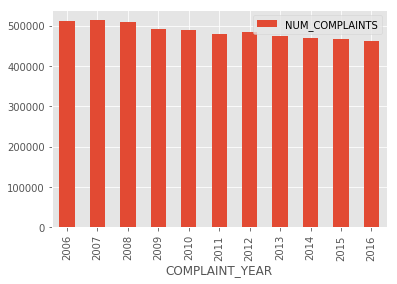

In [20]:
# Plot number of complaints per year
complaint_start_result.sort_values('COMPLAINT_YEAR').plot(kind = 'bar', x = 'COMPLAINT_YEAR', y = 'NUM_COMPLAINTS')

Looks better to me! Crime is decreasing - yay?

### Length Of Incident
Before I go ahead and look at any more time-series trends, I want to stop and take a look at the length of incidents because it's quite clear that typos exist in the data. This is an after-the-fact data cleansing exercise as my trust is a bit shaken right now.

In [21]:
# Generate summary statistics for complaint length
complaint_length_summary = df_filtered[['COMPLAINT_LENGTH']].describe().toPandas()
complaint_length_summary

,summary,COMPLAINT_LENGTH
0,count,5349485
1,mean,5038.090861266708
2,stddev,63724.48415252135
3,min,-5258880.0
4,max,4.26024E7


Remember, I loaded these up to be in _**minutes**_... I probably should have genereated them as hours or days haha. Let's do days...

In [22]:
# Add additional column expressing length of complaint in days
complaint_length_summary['COMPLAINT_LENGTH_DAYS'] = complaint_length_summary['COMPLAINT_LENGTH'].astype(float)/60/24
complaint_length_summary

,summary,COMPLAINT_LENGTH,COMPLAINT_LENGTH_DAYS
0,count,5349485,3714.920139
1,mean,5038.090861266708,3.498674
2,stddev,63724.48415252135,44.253114
3,min,-5258880.0,-3652.000000
4,max,4.26024E7,29585.000000


The average crime is 3.5 days, with a standard deviation of 1.5 months (44 days)... That seems _**very long**_... especially when I take a look at the max value, which is _**82 years long**_. More typos are coming...

<img src="http://www.newstatesman.com/sites/default/files/styles/nodeimage/public/blogs_2015/06/sean-bean.jpg" width="400">

Ugh, I thought I was done with the cleansing step last post - it has a way of just pulling you pack in. I guess we'll have to take a look at the complaint end date as well.

In [23]:
complaint_end_result = %read_sql \
SELECT \
    COMPLAINT_END_TIMESTAMP_YEAR as COMPLAINT_END_YEAR, \
    COUNT(*) as NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY COMPLAINT_END_TIMESTAMP_YEAR

Query started at 05:05:19 AM UTC; Query executed in 0.04 m

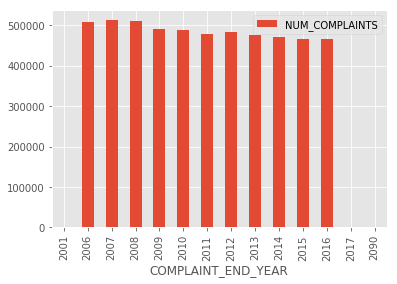

In [24]:
# Plot complaint ends per year
complaint_end_result.sort_values('COMPLAINT_END_YEAR').plot(kind = 'bar', x = 'COMPLAINT_END_YEAR', y = 'NUM_COMPLAINTS')

Well the 2001, 2017, and 2090 values definitely explain some of the bad summary statistics... Let's filter these out too.

In [25]:
# Filter end date for 2006 - 2016 inclusive
df_filtered = df_filtered[(df_filtered['COMPLAINT_END_TIMESTAMP_YEAR'] >= 2006) & (df_filtered['COMPLAINT_END_TIMESTAMP_YEAR'] <= 2016)]

In [26]:
# Add table to SQL Context
df_filtered.createOrReplaceTempView("df_filtered")

In [27]:
complaint_end_result = %read_sql \
SELECT \
    COMPLAINT_END_TIMESTAMP_YEAR as COMPLAINT_END_YEAR, \
    COUNT(*) as NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY COMPLAINT_END_TIMESTAMP_YEAR

Query started at 05:05:27 AM UTC; Query executed in 0.04 m

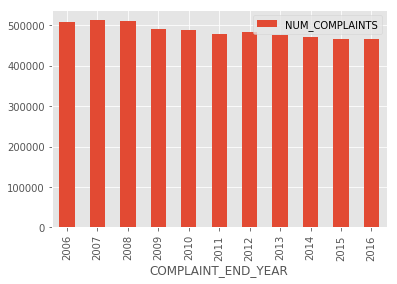

In [28]:
# Plot complaint ends per year
complaint_end_result.sort_values('COMPLAINT_END_YEAR').plot(kind = 'bar', x = 'COMPLAINT_END_YEAR', y = 'NUM_COMPLAINTS')

Let's try calculating complaint length summary statistics again.

In [29]:
# Generate summary statistics for complaint length
complaint_length_summary = df_filtered[['COMPLAINT_LENGTH']].describe().toPandas()
complaint_length_summary['COMPLAINT_LENGTH_DAYS'] = complaint_length_summary['COMPLAINT_LENGTH'].astype(float)/60/24
complaint_length_summary

,summary,COMPLAINT_LENGTH,COMPLAINT_LENGTH_DAYS
0,count,5349482,3714.918056
1,mean,5031.106929789339,3.493824
2,stddev,60962.561283018484,42.335112
3,min,-601920.0,-418.000000
4,max,5496660.0,3817.125000


You know what, this would actually be a very good use of a histogram... I secretly have been holding out on histograms because, embarassingly enough, _**how do I actually plot a histogram in Spark?**_ I don't think Spark has a graphing library... It looks like there's a library called **pyspark\_dist\_explore** that leverages Spark to compute the histogram bins and uses.

In [30]:
from pyspark_dist_explore import hist

(array([  5.14227700e+06,   2.00155000e+05,   4.43700000e+03,
          1.40000000e+03,   5.75000000e+02,   3.52000000e+02,
          1.62000000e+02,   6.80000000e+01,   4.10000000e+01,
          1.50000000e+01]),
 array([ -601920.,     7938.,   617796.,  1227654.,  1837512.,  2447370.,
         3057228.,  3667086.,  4276944.,  4886802.,  5496660.]),
 <a list of 10 Patch objects>)

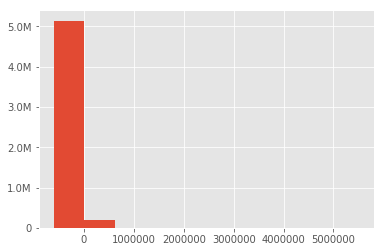

In [31]:
fig, ax = plt.subplots()
hist(ax, df_filtered[['COMPLAINT_LENGTH']], bins = 10)

Let's create a days column and plot that instead.

In [32]:
# Create permenant COMPLAINT_LENGTH_DAYS column
df_filtered = df_filtered.withColumn('COMPLAINT_LENGTH_DAYS', df['COMPLAINT_LENGTH']/60/24)

(array([  5.14227700e+06,   2.00155000e+05,   4.43700000e+03,
          1.40000000e+03,   5.75000000e+02,   3.52000000e+02,
          1.62000000e+02,   6.80000000e+01,   4.10000000e+01,
          1.50000000e+01]),
 array([ -418.    ,     5.5125,   429.025 ,   852.5375,  1276.05  ,
         1699.5625,  2123.075 ,  2546.5875,  2970.1   ,  3393.6125,
         3817.125 ]),
 <a list of 10 Patch objects>)

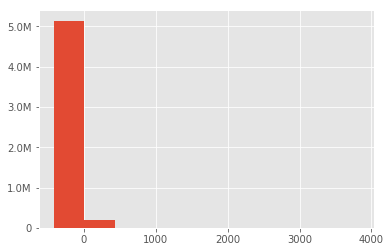

In [33]:
fig, ax = plt.subplots()
hist(ax, df_filtered[['COMPLAINT_LENGTH_DAYS']], bins = 10)

The output of hist() from the **pyspark\_dist\_explore** package gives us two arrays:
1. First array returns the count per histogram bin
2. Second array returns the lower boundary of the respective bin

Remember, our mean was around 3 days and the standard deviation was like 40 days, so theoretically most of the data should lie between like 0 and 200 days, 200 days is probably being generous. Here, our buckets are a bit too large, so let's try to break it up by more buckets.

(array([  5.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   5.14226700e+06,   1.63523000e+05,
          1.89480000e+04,   8.09500000e+03,   4.24400000e+03,
          5.34500000e+03,   1.27300000e+03,   9.64000000e+02,
          7.03000000e+02,   1.06700000e+03,   4.30000000e+02,
          3.54000000e+02,   2.65000000e+02,   4.37000000e+02,
          1.82000000e+02,   1.62000000e+02,   1.34000000e+02,
          1.22000000e+02,   1.65000000e+02,   8.80000000e+01,
          6.60000000e+01,   7.80000000e+01,   1.25000000e+02,
          6.30000000e+01,   5.00000000e+01,   3.60000000e+01,
          5.40000000e+01,   3.30000000e+01,   2.50000000e+01,
          2.90000000e+01,   2.10000000e+01,   1.20000000e+01,
          2.10000000e+01,   1.30000000e+01,   1.30000000e+01,
          9.00000000e+00,   1.40000000e+01,   7.00000000e+00,
          9.00000000e+00,   6.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   1.00000000e+00,
        

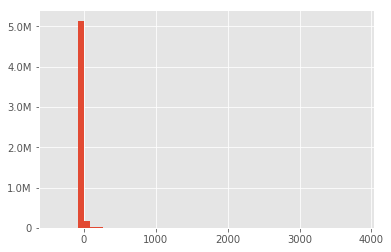

In [34]:
fig, ax = plt.subplots()
hist(ax, df_filtered[['COMPLAINT_LENGTH_DAYS']], bins = 50)

I think 0 - 500 is my sweet spot. Let's just do a quick sanity check to see how many records are between 0 - 500. Anything under 0 doesn't make sense, and is likely an error (how can an incident end before it starts)? If it's over 500... well the histogram tells us that it is quite an outlier... I'll take these out for now just to make my own life easier. I mean, theoretically anything over 365 days is a bit shady to me... a crime that lasts longer than _**a year**_? I'm not sure about that. In fact, why don't I actually make _**that**_ my cutoff!

In [36]:
# Create flag to determine whether or not length of complaint in days is under a year
df_filtered = df_filtered.withColumn(
    'COMPLAINT_LENGTH_UNDER_ONE_YEAR', 
    F.when((df_filtered['COMPLAINT_LENGTH_DAYS'] >= 0) & (df_filtered['COMPLAINT_LENGTH_DAYS'] <= 365), True) \
        .otherwise(False)
)

In [37]:
# Add table to SQL Context
df_filtered.createOrReplaceTempView("df_filtered")

In [39]:
complaint_length_groupby = %read_sql SELECT \
    COMPLAINT_LENGTH_UNDER_ONE_YEAR, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY \
    COMPLAINT_LENGTH_UNDER_ONE_YEAR

Query started at 05:28:07 AM UTC; Query executed in 0.31 m

In [43]:
# Add percentages column
complaint_length_groupby['NUM_COMPLAINTS_PERCENTAGE'] = (complaint_length_groupby['NUM_COMPLAINTS'] / complaint_length_groupby['NUM_COMPLAINTS'].sum())*100
complaint_length_groupby

,COMPLAINT_LENGTH_UNDER_ONE_YEAR,NUM_COMPLAINTS,NUM_COMPLAINTS_PERCENTAGE
0,True,5336177,99.751284
1,False,13305,0.248716


Once again, barely any of the rows fall over a year or take on a negative value, so I feel comfortable discarding these as well. Let's make the change in the original Spark dataframe.

In [45]:
# Filter for those with complaint lengths under one year
df_filtered = df_filtered[(df_filtered['COMPLAINT_LENGTH_DAYS'] >= 0) & (df_filtered['COMPLAINT_LENGTH_DAYS'] <= 365)]

(array([  5.26775800e+06,   2.85530000e+04,   1.40430000e+04,
          7.75800000e+03,   5.70600000e+03,   3.95300000e+03,
          2.72000000e+03,   2.18300000e+03,   1.64000000e+03,
          1.86300000e+03]),
 array([   0. ,   36.5,   73. ,  109.5,  146. ,  182.5,  219. ,  255.5,
         292. ,  328.5,  365. ]),
 <a list of 10 Patch objects>)

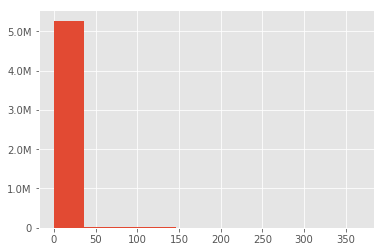

In [53]:
fig, ax = plt.subplots()
hist(ax, df_filtered[['COMPLAINT_LENGTH_DAYS']], bins = 10)

This looks fine to me for now. I'm inferring that the large large majority of the crimes are actually 0 days long (i.e. was a single instance in time, starting and ending at the exact same moment). Let's confirm this:

In [49]:
complaint_length_groupby = %read_sql SELECT \
    COMPLAINT_LENGTH_ZERO_TIME, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY \
    COMPLAINT_LENGTH_ZERO_TIME

Query started at 05:42:27 AM UTC; Query executed in 0.31 m

In [50]:
# Add percentages column
complaint_length_groupby['NUM_COMPLAINTS_PERCENTAGE'] = (complaint_length_groupby['NUM_COMPLAINTS'] / complaint_length_groupby['NUM_COMPLAINTS'].sum())*100
complaint_length_groupby

,COMPLAINT_LENGTH_ZERO_TIME,NUM_COMPLAINTS,NUM_COMPLAINTS_PERCENTAGE
0,True,1624422,30.365968
1,False,3725060,69.634032


Ah, not quite, maybe within 1-2 days?

(array([ 4664431.,   253271.,    68966.,    39104.,    29337.,    25091.,
           18190.,    12244.,    11944.,    10079.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

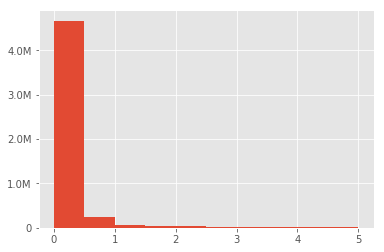

In [54]:
fig, ax = plt.subplots()
hist(ax, df_filtered[df_filtered['COMPLAINT_LENGTH_DAYS'] <= 5][['COMPLAINT_LENGTH_DAYS']], bins = 10)

Finally, we get to a histogram that actually gives me a good sense of the distribution of complaint lengths.
- ~90% of the incidents took less than half a day (remember that a length of 0 makes up about 1/3 of all the rows in the dataset)
- Maybe ~3-4% take half a day to a day to complete
- The rest take over a day to complete, up to our arbitrary limit of 365 days (1 year)

Let's move on.

### Monthly, Daily, Weekly Trends
#### Monthly
Let's take a look at how many crimes happen per month, day of week, and day of month.

In [56]:
# Add table to SQL Context
df_filtered.createOrReplaceTempView("df_filtered")

In [59]:
monthly_result = %read_sql \
SELECT \
    CAST(COMPLAINT_START_TIMESTAMP_MONTH AS INT) AS COMPLAINT_MONTH, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY COMPLAINT_START_TIMESTAMP_MONTH

Query started at 05:58:02 AM UTC; Query executed in 0.32 m

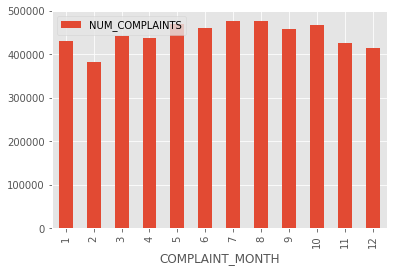

In [65]:
# Plot number of complaints per month
monthly_result.sort_values('COMPLAINT_MONTH', ascending = True).plot(kind = 'bar', x = 'COMPLAINT_MONTH', y = 'NUM_COMPLAINTS')

More complaints during the summer months and very few complaints in February. I actually think this is because we're February has less days than the rest of the months. Nothing else that's too out of the ordinary here. Winter in NYC can be cold, perhaps not as many crimes open to being committed.

#### Daily

In [66]:
daily_result = %read_sql \
SELECT \
    CAST(COMPLAINT_START_TIMESTAMP_DAY AS INT) AS COMPLAINT_DAY, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY COMPLAINT_START_TIMESTAMP_DAY

Query started at 06:01:36 AM UTC; Query executed in 0.31 m

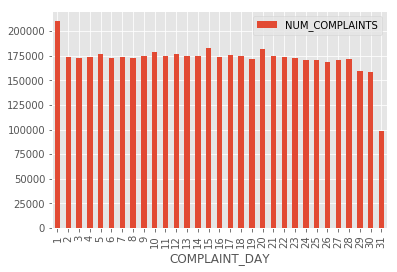

In [67]:
# Plot number of complaints per day
daily_result.sort_values('COMPLAINT_DAY', ascending = True).plot(kind = 'bar', x = 'COMPLAINT_DAY', y = 'NUM_COMPLAINTS')

We see the effect of February again with the drops in the 29th, 30th, and 31st of the month. 31st of the month is missing by half the months as well, of course, so relatively, it's actually quite high.

A few dates pop out for some reason.
- There are far more complaints than average on the 1st
- There are slightly more complaints than average on the 5th, 10th, 15th, and 20th

The first point I could see. The 1st of every month is a milestone. If someone gets paid the first of the month, maybe that would Spark a theft or burglary... there are lots of reasons why someone would plan something on the first of every month because it's just a simple, easy to remember date. From that, crimes and complaints may revolve around these events that happen.

The second point, I'm not so sure... I honestly have no clue right now. I'll have to do more research and come back to this later.

In [70]:
weekday_result = %read_sql \
SELECT \
    COMPLAINT_START_TIMESTAMP_WEEKDAY AS COMPLAINT_WEEKDAY, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY COMPLAINT_START_TIMESTAMP_WEEKDAY

Query started at 06:12:36 AM UTC; Query executed in 0.11 m

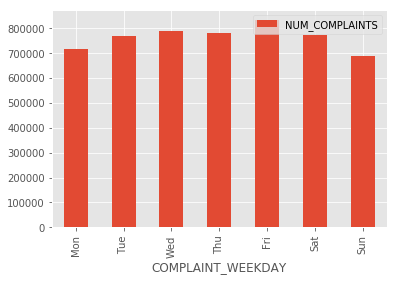

In [75]:
# Plot number of complaints per weekday
weekday_result.reindex([1, 5, 4, 2, 6, 3, 0]).plot(kind = 'bar', x = 'COMPLAINT_WEEKDAY', y = 'NUM_COMPLAINTS')

More complaints on Fridays, less on Mondays and Sundays... I can see both of these. Same amount of complaints on a Wednesday vs a Saturday? I would've thought Saturday would be filled with the most complaints, but good to know what the data says.